# Lotka-Volterra
Solve the Lotka-Volterra equations using Explicit Runge-Kutta Methods

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))
import rungekutta as rk
import numpy as np
import pandas as pd
from plotnine import *
import time

## Setup Lotka-Volterra System

In [2]:
class LotkaVolterra:
    def __init__(self, alpha, beta, gamma, delta):
        self.alpha = alpha; self.beta = beta
        self.gamma = gamma; self.delta = delta
    
    def __call__(self, y, t):
        return np.array(
            [self.alpha * y[0] - self.beta * y[0] * y[1],
            self.delta * y[0] * y[1] - self.gamma * y[1]], dtype=float)

## Setup Solvers
Solve using multiple Explicit Solvers \
The Explicit Solvers are initialized with their 'Butcher Tableau' which defines the method \
```python3
ExplicitSolver(weights array, nodes array, runge_kutta matrix)
```

In [3]:
system = LotkaVolterra(2/3, 4/3, 1, 1)
forward_euler = rk.ExplicitSolver([0], [1], [[0]])
midpoint = rk.ExplicitSolver([0, 0.5], [0, 1], [[0, 0], [1/2, 0]])
fourth_order = rk.ExplicitSolver([0, 0.5, 0.5, 1], [1/6, 1/3, 1/3, 1/6],
    [[0,0,0,0], [1/2,0,0,0], [0,1/2,0,0], [0,0,1,0]])
dormand_prince = rk.ExplicitSolver([0,1/5,3/10,4/5,8/9,1,1], [35/384,0,500/1113,125/192,-2187/6784,11/84,0],
    [[0,0,0,0,0,0,0],[1/5,0,0,0,0,0,0],[3/40,9/40,0,0,0,0,0],[44/45,-56/15,32/9,0,0,0,0],
    [19372/6561,-25360/2187,64448/6561,-212/729,0,0,0],
    [9017/3168,-355/33,46732/5247,49/176,-5103/18656,0,0],
    [35/384,0,500/1113,125/192,-2187/6784,11/84,0]])

solvers = {
    'forward_euler': forward_euler,
    'explicit_midpoint': midpoint,
    'fourth_order_runge_kutta': fourth_order,
    'dormand_prince': dormand_prince}
for s in solvers: solvers[s].set_func(system)

## Solve using each of the Solvers with different step_sizes

In [4]:
df_results = pd.DataFrame()
df_performance = pd.DataFrame()
step_sizes = np.logspace(-4, -1, num=4, base=10, dtype=float)
times = np.linspace(0, 20, 100)

for step_size in step_sizes:
    for solver in solvers:
        print(f'\rSolving using {solver} with step size: {step_size:.1e}' + ' '*50, end='')
        t0 = time.perf_counter()
        y = solvers[solver].solve_times(times, y0=[1,1], t0=0, step_size=step_size)
        t1 = time.perf_counter()

        for ti, ui, vi in zip(times, y[:, 0], y[:, 1]): df_results = df_results.append({'t': ti, 'u': ui, 'v': vi, 'method': solver, 'step_size': str(step_size)}, ignore_index=True)
        df_performance = df_performance.append({'step_size': step_size, 'method': solver, 'time': t1-t0}, ignore_index=True)

Solving using dormand_prince with step size: 1.0e-01                                                            

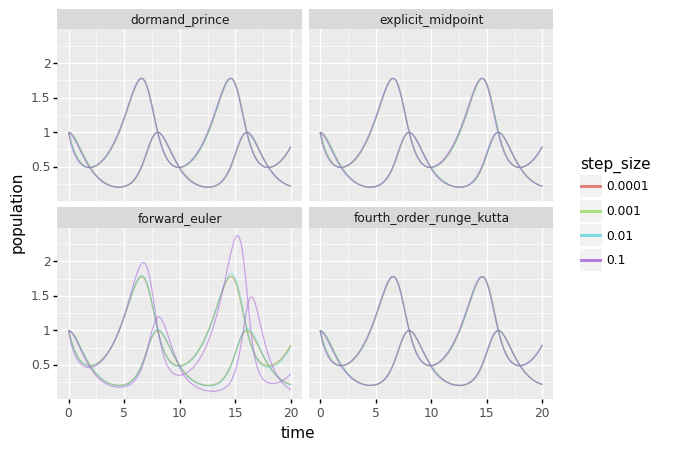

<ggplot: (8778913992906)>

In [5]:
(
    ggplot(df_results, aes(x='t')) +
    geom_line(aes(y='u', group='step_size', colour='step_size'), alpha=0.5) +
    geom_line(aes(y='v', group='step_size', colour='step_size'), alpha=0.5) +
    facet_wrap('method') +
    ylab('population') + xlab('time')
)

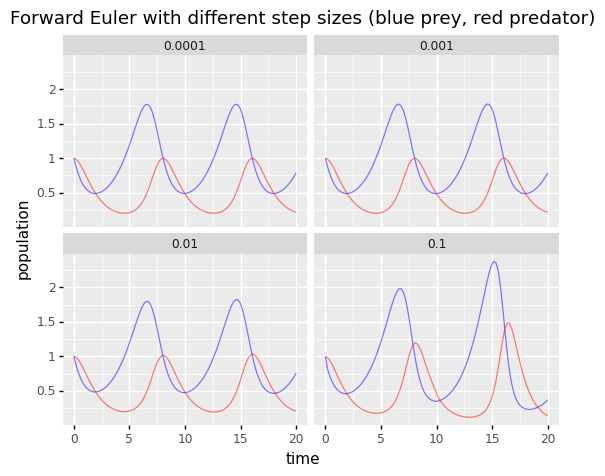

<ggplot: (8778914012922)>

In [6]:
(
    ggplot(df_results.query('method=="forward_euler"'), aes(x='t')) +
    geom_line(aes(x='t', y='u'), color='blue', alpha=0.5) +
    geom_line(aes(x='t', y='v'), color='red', alpha=0.5) +
    facet_wrap('step_size') +
    ylab('population') + xlab('time') +
    ggtitle('Forward Euler with different step sizes (blue prey, red predator)')
)

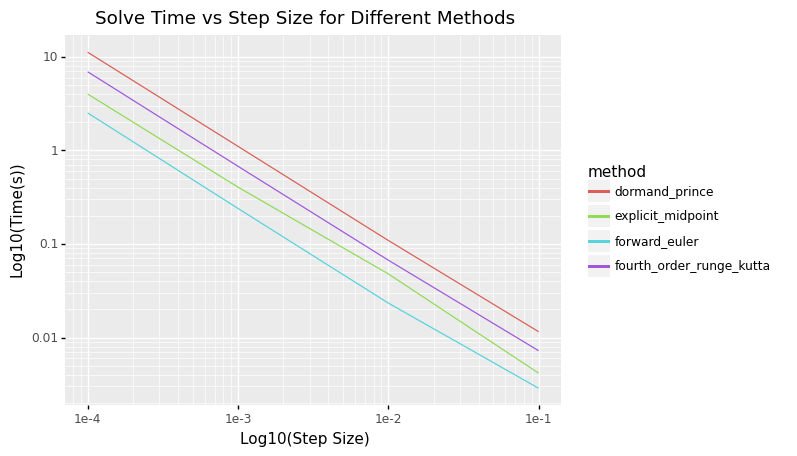

<ggplot: (8778909958533)>

In [7]:
(
    ggplot(df_performance, aes(x='step_size', y='time')) +
    geom_line(aes(group='method', color='method')) +
    scale_x_log10() + scale_y_log10() +
    ggtitle('Solve Time vs Step Size for Different Methods') +
    xlab('Log10(Step Size)') + ylab('Log10(Time(s))')
)

## Compare these solutions to scipy.integrate.odeint

In [8]:
import scipy.integrate

class ScipyComparator:
    def __init__(self, function, initial, times):
        self.truth = scipy.integrate.odeint(system, [1,1], times)
    
    def error(self, other, j=0):
        error = 0
        for i in range(other.shape[0]):
            error += (other[i] - self.truth[i, j])*(other[i]-self.truth[i, j])
        return np.sqrt(error / other.shape[0])
compare = ScipyComparator(system, [1,1], times)

df_errors = pd.DataFrame(columns=('method', 'step_size', 'u_rms_error', 'v_rms_error', 'avg_rms_error'))
index = pd.MultiIndex.from_frame(df_results[["method", "step_size"]])
df_grouped = df_results.set_index(index)
for i in index.unique():
    u_err = compare.error(df_grouped.loc[i]["u"], 0)
    v_err = compare.error(df_grouped.loc[i]["v"], 1)
    df_errors = df_errors.append({
        'method': i[0], 'step_size': float(i[1]), 'u_rms_error': u_err, 'v_rms_error': v_err, 'avg_rms_error':(u_err+v_err)/2}, ignore_index=True)

/tmp/ipykernel_37384/3897684558.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/tmp/ipykernel_37384/3897684558.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.


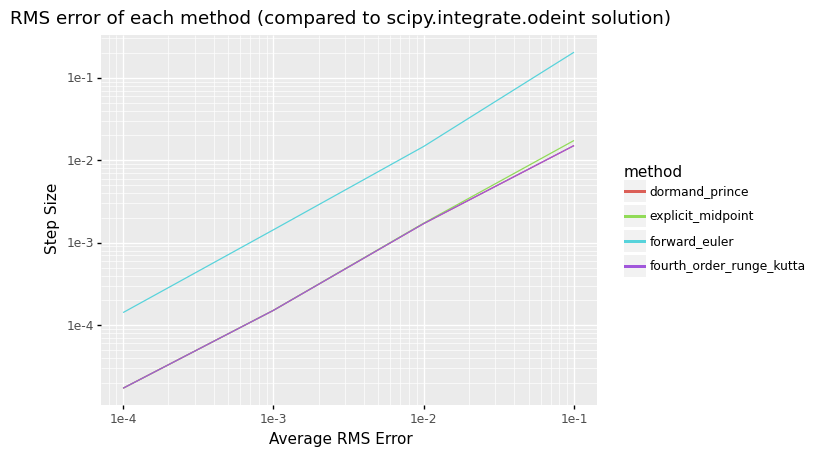

<ggplot: (8778911659969)>

In [9]:
(
    ggplot(df_errors, aes(x='step_size')) +
    geom_line(aes(y='avg_rms_error', colour='method')) +
    scale_x_log10() + scale_y_log10() +
    ggtitle("RMS error of each method (compared to scipy.integrate.odeint solution)") +
    xlab('Average RMS Error') + ylab('Step Size')
)